# Анализ энергопотребления и выявление аномалий

В данной курсовой работе приведен анализ энергопотребления на основе датасета *HomeC.csv* (https://www.kaggle.com/datasets/taranvee/smart-home-dataset-with-weather-information?resource=download) с целью выявления аномальных событий. Я использовала такие статистические методы, как z-score, IQR, скользящие средние и алгоритмы машинного обучения (Isolation Forest, DBSCAN) для обнаружения выбросов.

In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для отображения графиков в ноутбуке
%matplotlib inline

# Загрузка датасета HomeC.csv
df = pd.read_csv('HomeC.csv')

# Вывод размера набора данных и первых строк
print("Размер набора данных:", df.shape)
display(df.head(5))

Размер набора данных: (64526, 32)


<ipython-input-2-e5554d8d0ed1>:11: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('HomeC.csv')


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


# Описание столбцов датасета

**time**  
- **Описание:** Метка времени в формате Unix (количество секунд, прошедших с 1 января 1970 года).  
- **Тип данных:** Числовой (целое число).  
- **Назначение:** Используется для определения момента измерения (дата и время).  
- **Примечание:** Обычно переводится в человекочитаемый формат с помощью `pd.to_datetime(..., unit='s')`.

---

**use [kW]**  
- **Описание:** Текущее энергопотребление дома из электросети (в киловаттах).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Показывает, сколько энергии дом берёт из сети в данный момент. Может учитываться как «полное» или «сетевая» часть потребления, если присутствует генерация.

---

**gen [kW]**  
- **Описание:** Генерация энергии (в киловаттах) — например, от солнечных панелей или других источников.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Отражает, сколько энергии производится в данный момент и (в некоторых версиях) отдаётся в сеть или потребляется домом.

---

**House overall [kW]**  
- **Описание:** Суммарное потребление дома в киловаттах (может совпадать или отличаться от `use [kW]` в зависимости от учета солнечной генерации).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Отражает «общую» нагрузку дома (все приборы), без учета или с учетом генерации. Часто используется для анализа суммарной нагрузки.

---

**Furnace 1 [kW]**  
- **Описание:** Потребление первой печи (системы отопления) в киловаттах.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Позволяет понять вклад первого контура отопления в общее энергопотребление.

---

**Furnace 2 [kW]**  
- **Описание:** Потребление второй печи (отопительной системы).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Аналогично Furnace 1, но для второго контура. Если оба включаются одновременно, общее потребление резко возрастает.

---

**Dishwasher [kW]**  
- **Описание:** Потребление посудомоечной машины.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Анализ загрузки посудомойки и её вклад в пиковые нагрузки.

---

**Home office [kW]**  
- **Описание:** Потребление «домашнего офиса» — розетки, компьютер, принтер и т.д.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Позволяет понять, как часто используется офисная техника и насколько она влияет на общий расход.

---

**Fridge [kW]**  
- **Описание:** Потребление холодильника.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Оценка вклада холодильника, который циклически включается и выключается.

---

**Wine cellar [kW]**  
- **Описание:** Потребление винного погреба (если он охлаждается).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Аналогично холодильнику, но для отдельного помещения.

---

**Garage door [kW]**  
- **Описание:** Потребление привода гаражных ворот.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Обычно почти нулевое, кроме моментов открытия/закрытия ворот.

---

**Kitchen 12 [kW], Kitchen 14 [kW], Kitchen 38 [kW]**  
- **Описание:** Различные цепи кухни, обозначенные номерами (например, розетки, подсветка, плита и т.д.).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Позволяет анализировать, какие зоны кухни потребляют больше всего энергии.

---

**Barn [kW]**  
- **Описание:** Потребление сарая (подсветка, оборудование).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Если есть хозяйственные постройки, этот столбец показывает их вклад в энергопотребление.

---

**Well [kW]**  
- **Описание:** Потребление колодезного насоса (если имеется).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Насос может включаться периодически, вызывая кратковременные скачки нагрузки.

---

**Microwave [kW]**  
- **Описание:** Потребление микроволновой печи.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Дает кратковременные, но часто высокие всплески потребления.

---

**Living room [kW]**  
- **Описание:** Потребление гостиной (освещение, ТВ, аудиосистема).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Помогает понять, когда люди находятся в гостиной, используют бытовую технику.

---

**Solar [kW]**  
- **Описание:** Выработка энергии солнечными панелями в киловаттах.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Показывает, сколько энергии производится от солнечного света, что влияет на общий баланс энергопотребления.

---

**temperature**  
- **Описание:** Температура воздуха снаружи (скорее всего, в °F).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Важна для анализа влияния погоды на потребление энергии (например, для отопления).

---

**icon**  
- **Описание:** Краткое текстовое описание погоды (например, `"clear-day"`, `"clear-night"`, `"partly-cloudy-day"`).  
- **Тип данных:** Строковый (object).  
- **Назначение:** Используется для категоризации погодных условий (ясно, пасмурно, дождь и т.д.).

---

**humidity**  
- **Описание:** Влажность воздуха (в диапазоне 0–1 или в процентах).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Может влиять на восприятие температуры и косвенно отражать погодные условия.

---

**visibility**  
- **Описание:** Видимость (обычно в милях или километрах).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Отражает погодные условия (например, туман или осадки), что может влиять на эффективность солнечной генерации.

---

**summary**  
- **Описание:** Более развернутое текстовое описание погоды (например, `"Clear throughout the day"`).  
- **Тип данных:** Строковый (object).  
- **Назначение:** Предоставляет детальное описание погодных условий, может дополнять `icon`.

---

**apparentTemperature**  
- **Описание:** «Ощущаемая» температура (с учётом ветра и влажности, в °F).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Показывает, насколько на самом деле ощущается температура, что может влиять на работу систем отопления или кондиционирования.

---

**pressure**  
- **Описание:** Атмосферное давление (обычно в миллибарах или гПа).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Погодный параметр, влияющий на общее состояние атмосферы.

---

**windSpeed**  
- **Описание:** Скорость ветра (вероятно, в милях в час).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Может усиливать теплопотери дома, влияя на энергопотребление отопительной системой.

---

**cloudCover**  
- **Описание:** Степень облачности (значения от 0 до 1).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Отражает облачность – чем выше значение, тем меньше солнечная генерация.

---

**windBearing**  
- **Описание:** Направление ветра в градусах (например, 0 – север, 90 – восток).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Может уточнять влияние ветра, например, северный ветер может быть холоднее.

---

**precipIntensity**  
- **Описание:** Интенсивность осадков (дождь или снег, обычно в мм/ч или дюймах/ч).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Показывает наличие осадков, что косвенно влияет на погодные условия и энергопотребление.

---

**dewPoint**  
- **Описание:** Точка росы (в °F или °C), связана с температурой и влажностью.  
- **Тип данных:** Числовой (float).  
- **Назначение:** Дополнительный показатель, влияющий на оценку погодных условий.

---

**precipProbability**  
- **Описание:** Вероятность осадков (значения от 0 до 1).  
- **Тип данных:** Числовой (float).  
- **Назначение:** Прогноз вероятности дождя или снега, что может влиять на планирование использования приборов.


## 1. Предварительный анализ и очистка данных

В этом разделе столбец времени приведен к формату `datetime`, установлен в качестве индекса, также проверено наличие пропущенных значений, дубликатов и равномерность временной сетки.

In [ ]:
# Приведение метки времени к формату datetime
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('datetime')
df = df.drop(columns=['time'])

# Проверка пропущенных значений
missing_counts = df.isnull().sum()
print("Пропущенные значения:")
display(missing_counts[missing_counts > 0])

# Проверка дубликатов индекса (времени)
duplicate_times = df.index.duplicated().sum()
print("Число повторяющихся временных меток:", duplicate_times)

Пропущенные значения:


,0
House overall [kW],1
Dishwasher [kW],1
Furnace 1 [kW],1
Furnace 2 [kW],1
Home office [kW],1
Fridge [kW],1
Wine cellar [kW],1
Garage door [kW],1
Kitchen 12 [kW],1
Kitchen 14 [kW],1


Число повторяющихся временных меток: 0


### Проверка временной сетки

Проверяем, что данные записываются с равномерным шагом (ожидается, что шаг составляет примерно 1 секунду).

In [ ]:
time_diffs = df.index.to_series().diff().dropna().dt.total_seconds()
print("Средний шаг времени (сек):", time_diffs.mean(), "секунд")
print("Уникальные значения шага времени:", np.unique(time_diffs.values)[:5], "...")

Средний шаг времени (сек): 1.0 секунд
Уникальные значения шага времени: [1.] ...


## 2. Выявление закономерностей и трендов

На этом этапе проведен анализ суточного и недельного профиля энергопотребления (правда у меня в датасете всего 1 день, но можно использовать датасет с данными за несколько дней), а также исследована зависимость от погодных условий.

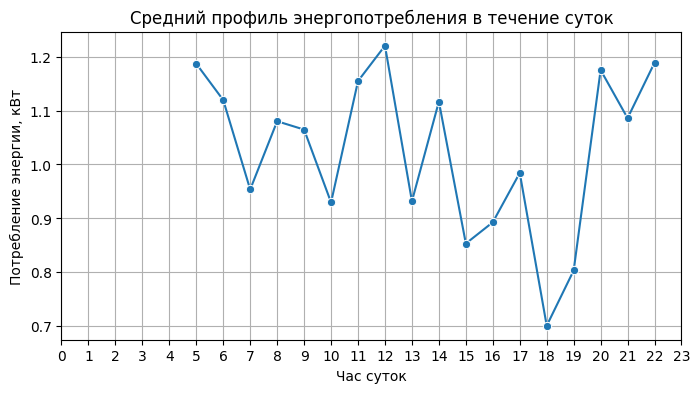

In [ ]:
# Добавляем признаки часа и дня недели
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  # 0 - понедельник, ..., 6 - воскресенье

# Расчет среднего потребления по каждому часу суток (используем столбец 'House overall [kW]')
hourly_profile = df.groupby('hour')['House overall [kW]'].mean()

# Построение графика среднего профиля нагрузки в сутки
plt.figure(figsize=(8,4))
sns.lineplot(x=hourly_profile.index, y=hourly_profile.values, marker='o')
plt.title("Средний профиль энергопотребления в течение суток")
plt.xlabel("Час суток")
plt.ylabel("Потребление энергии, кВт")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

### Анализ по дням недели

Посмотрим, как изменяется среднее дневное потребление по дням недели (столбец один, так как день всего один).

<ipython-input-20-61af01bc6320>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_profile.index, y=weekly_profile.values, palette="Blues_d")


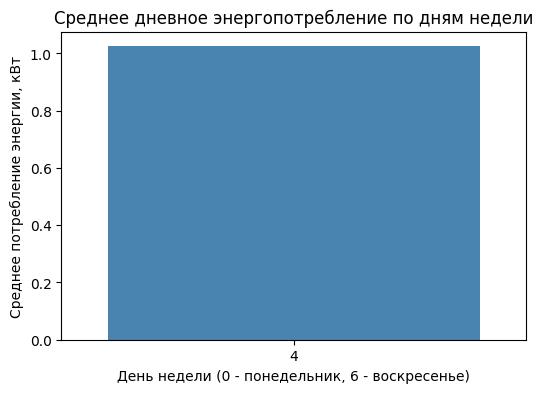

In [ ]:
# Среднее потребление по дням недели
weekly_profile = df.groupby('day_of_week')['House overall [kW]'].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=weekly_profile.index, y=weekly_profile.values, palette="Blues_d")
plt.title("Среднее дневное энергопотребление по дням недели")
plt.xlabel("День недели (0 - понедельник, 6 - воскресенье)")
plt.ylabel("Среднее потребление энергии, кВт")
plt.show()

### Сглаживание и тренды

Для выявления долгосрочных трендов и сезонных колебаний агрегируем данные до часового интервала и рассчитываем скользящие средние.

<ipython-input-7-a1b1afbfb488>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df['House overall [kW]'].resample('H').mean()


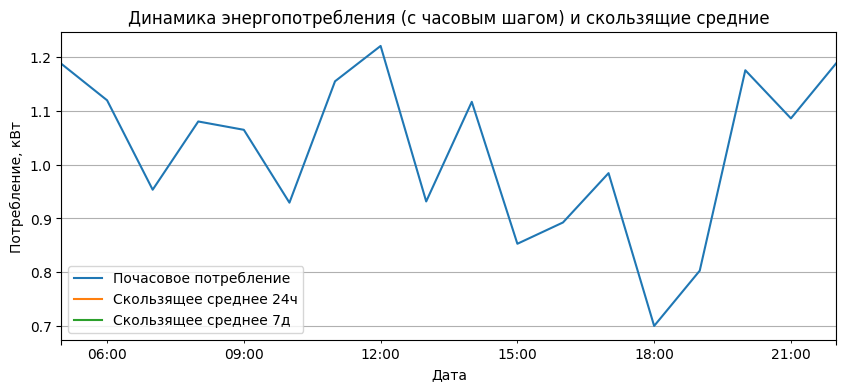

In [ ]:
# Ресемплирование временного ряда до часа (среднее за каждый час)
hourly_df = df['House overall [kW]'].resample('H').mean()
hourly_df = hourly_df.to_frame(name='house_kW')

# Скользящее среднее за 24 часа и за неделю
hourly_df['MA_24h'] = hourly_df['house_kW'].rolling(window=24, center=True).mean()
hourly_df['MA_7d'] = hourly_df['house_kW'].rolling(window=24*7, center=True).mean()

# Построение графика
plt.figure(figsize=(10,4))
hourly_df[['house_kW','MA_24h','MA_7d']].plot(ax=plt.gca())
plt.title("Динамика энергопотребления (с часовым шагом) и скользящие средние")
plt.xlabel("Дата")
plt.ylabel("Потребление, кВт")
plt.legend(["Почасовое потребление", "Скользящее среднее 24ч", "Скользящее среднее 7д"])
plt.grid(True)
plt.show()

### Корреляционный анализ

Построим корреляционную матрицу между основными признаками: суммарное потребление, температура, влажность, скорость ветра и солнечная генерация.

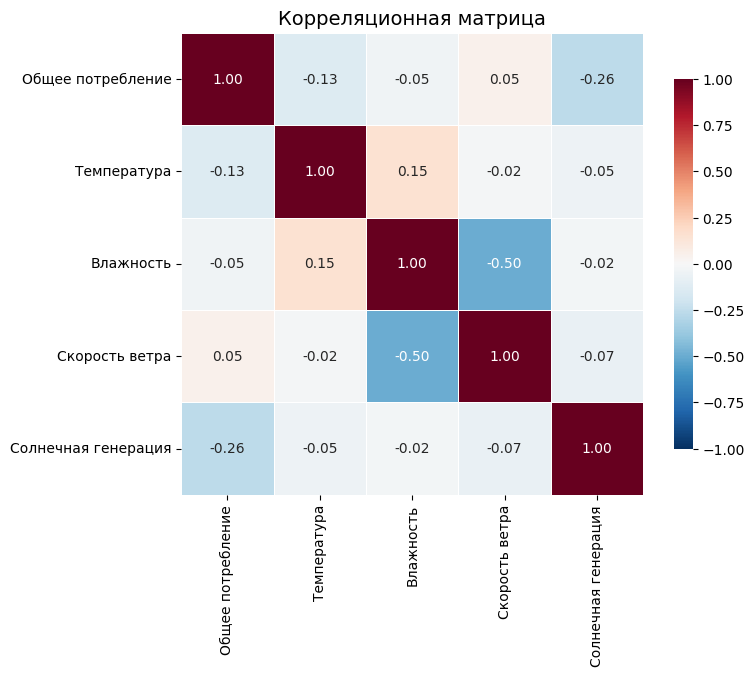

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cols_of_interest = [
    'House overall [kW]',
    'temperature',
    'humidity',
    'windSpeed',
    'Solar [kW]'
]

# Словарь переименования столбцов на русский
rename_dict = {
    'House overall [kW]': 'Общее потребление',
    'temperature': 'Температура',
    'humidity': 'Влажность',
    'windSpeed': 'Скорость ветра',
    'Solar [kW]': 'Солнечная генерация'
}

# Создаём копию нужных столбцов
df_rus = df[cols_of_interest].copy()

# Переименовываем столбцы
df_rus.rename(columns=rename_dict, inplace=True)

# Вычисляем корреляционную матрицу
corr_matrix = df_rus.corr()

# Настраиваем размер и строим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Корреляционная матрица", fontsize=14)
plt.show()

# Интерпретация корреляционной матрицы

В данном анализе вычислена корреляционная матрица для следующих показателей:
- **Общее потребление**: суммарное энергопотребление дома (кВт);
- **Температура**: наружная температура (°F);
- **Влажность**: относительная влажность воздуха (0–1 или в процентах);
- **Скорость ветра**: скорость ветра (например, в милях/час);
- **Солнечная генерация**: выработка энергии солнечными панелями (кВт).

Ниже приведена тепловая карта, показывающая степень линейной связи между этими переменными.

1. **Общее потребление и Температура**  
   - **Отрицательная корреляция**: При понижении температуры (холодные дни) дом потребляет больше энергии для обогрева. Это означает, что когда температура снижается, наблюдается рост энергопотребления, и наоборот.

2. **Общее потребление и Солнечная генерация**  
   - **Отрицательная корреляция**: Когда солнечные панели вырабатывают больше энергии, часть потребностей дома покрывается этой генерацией, а нагрузка на сеть снижается.

3. **Общее потребление и Влажность**  
   - Обычно наблюдается **слабая корреляция**. Влажность может косвенно влиять на потребление (например, во влажную погоду может активнее работать система отопления), но её влияние не столь явно.

4. **Общее потребление и Скорость ветра**  
   - Обычно связь **слабая**. Однако сильный ветер может увеличивать теплопотери дома, что приводит к росту потребления, но эта связь зачастую не выражена сильно.

5. **Температура и Солнечная генерация**  
   - Связь может быть **слабой** или умеренной, в зависимости от климатических условий. В ясные дни при высокой температуре солнечные панели вырабатывают больше энергии, что снижает нагрузку на сеть.

6. **Температура и Влажность**  
   - Часто наблюдается **отрицательная корреляция**: в холодное время года воздух бывает суше, а при повышении температуры и испарениях влажность может расти.

7. **Влажность и Солнечная генерация**  
   - Может быть **отрицательной**: высокая влажность часто сопровождается облачностью, что снижает эффективность солнечных панелей.

### Визуализация зависимости потребления от температуры

Построим scatter plot для зависимости потребления дома от температуры.

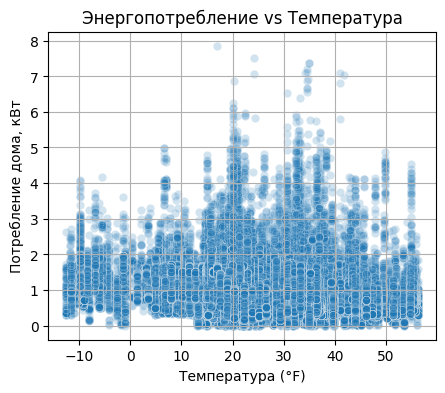

In [ ]:
plt.figure(figsize=(5,4))
sns.scatterplot(x=df['temperature'], y=df['House overall [kW]'], alpha=0.2)
plt.title("Энергопотребление vs Температура")
plt.xlabel("Температура (°F)")
plt.ylabel("Потребление дома, кВт")
plt.grid(True)
plt.show()

## 3. Выявление аномалий

Используем статистические методы (z-score, IQR) для первоначального выявления выбросов.

In [ ]:
# Статистический метод: z-score
consumption = df['House overall [kW]']
z_scores = (consumption - consumption.mean()) / consumption.std()
outliers_z = consumption[abs(z_scores) > 3]
print("Число выбросов по критерию |z| > 3:", len(outliers_z))

# Метод IQR
Q1 = consumption.quantile(0.25)
Q3 = consumption.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = consumption[(consumption < lower_bound) | (consumption > upper_bound)]
print("Число выбросов по IQR-критерию:", len(outliers_iqr))
print(f"Границы IQR: нижняя = {lower_bound:.2f}, верхняя = {upper_bound:.2f} кВт")

Число выбросов по критерию |z| > 3: 1097
Число выбросов по IQR-критерию: 1785
Границы IQR: нижняя = -0.71, верхняя = 2.61 кВт


### Визуализация одного из аномальных всплесков

Выберем один из выбросов, обнаруженных по IQR-критерию, и посмотрим, как выглядит временной ряд вокруг него.

Примеры аномально высоких значений:


,House overall [kW]
datetime,
2016-01-01 05:00:27,2.642517
2016-01-01 05:10:22,3.393350
2016-01-01 05:10:23,2.696950
2016-01-01 05:10:31,2.941367
2016-01-01 05:10:32,3.368067


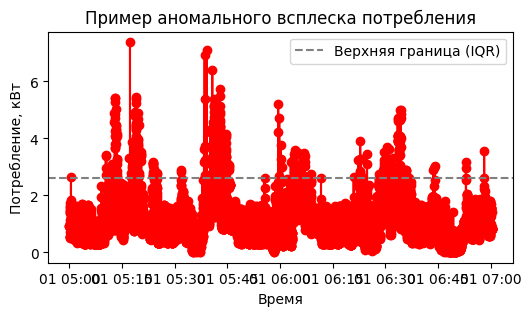

In [ ]:
outliers_iqr_high = consumption[consumption > upper_bound]
print("Примеры аномально высоких значений:")
display(outliers_iqr_high.head(5))

# Визуализируем один из аномальных всплесков
if len(outliers_iqr_high) > 0:
    sample_time = outliers_iqr_high.index[0]
    start = sample_time - pd.Timedelta(hours=1)
    end = sample_time + pd.Timedelta(hours=2)
    sample_window = df.loc[start:end, 'House overall [kW]']
    plt.figure(figsize=(6,3))
    plt.plot(sample_window.index, sample_window.values, marker='o', color='red')
    plt.axhline(y=upper_bound, color='gray', linestyle='--', label='Верхняя граница (IQR)')
    plt.title("Пример аномального всплеска потребления")
    plt.xlabel("Время")
    plt.ylabel("Потребление, кВт")
    plt.legend()
    plt.show()

### Обнаружение аномалий с помощью методов машинного обучения

Применим алгоритмы Isolation Forest и DBSCAN для выявления аномалий с учётом нескольких признаков. Будем использовать признаки: `House overall [kW]`, `temperature` и `Solar [kW]`.

Для ускорения расчётов ресемплируем данные с шагом 5 минут.

In [ ]:
# Ресемплирование данных с шагом 5 минут
df_5min = df.resample('5min').mean(numeric_only=True).dropna()

# Выбираем признаки для модели
features = df_5min[['House overall [kW]', 'temperature', 'Solar [kW]']].copy()

# Нормализуем данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(features)

#### Isolation Forest

Обучим модель Isolation Forest для обнаружения аномалий. Выберем параметр contamination = 0.005 (примерно 0.5% аномальных точек).

In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.005, random_state=42)
model.fit(X)
anomaly_scores = model.decision_function(X)
anomalies_if = model.predict(X)  # -1 для аномалий, 1 для нормальных

print("Аномалий, найденных Isolation Forest:", list(anomalies_if).count(-1))

Аномалий, найденных Isolation Forest: 2


#### Визуализация результатов Isolation Forest

Отобразим аномалии, найденные Isolation Forest, на графике почасового потребления (ресемплированном с шагом 5 минут).

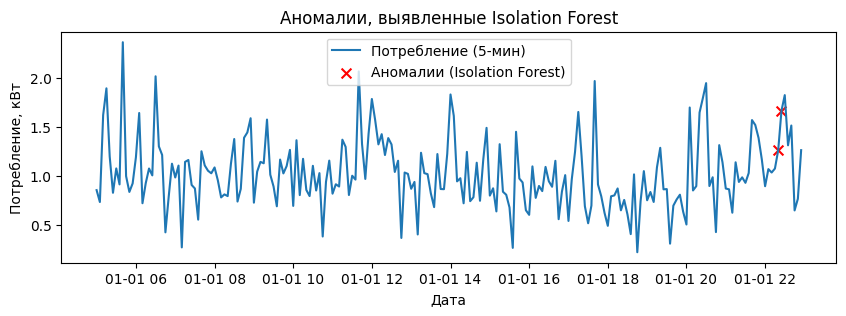

In [ ]:
# Выбираем индексы аномалий
anomaly_indices = df_5min.index[anomalies_if == -1]

plt.figure(figsize=(10,3))
plt.plot(df_5min.index, df_5min['House overall [kW]'], label='Потребление (5-мин)')
plt.scatter(anomaly_indices, df_5min.loc[anomaly_indices, 'House overall [kW]'],
            color='red', marker='x', s=50, label='Аномалии (Isolation Forest)')
plt.title("Аномалии, выявленные Isolation Forest")
plt.xlabel("Дата")
plt.ylabel("Потребление, кВт")
plt.legend()
plt.show()

#### DBSCAN

Применим алгоритм DBSCAN для обнаружения аномалий на тех же стандартизированных данных.

In [ ]:
from sklearn.cluster import DBSCAN

# Применяем DBSCAN с параметрами eps=0.5 и min_samples=5
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)
outlier_dbscan_indices = df_5min.index[labels == -1]
print("Аномалий, найденных DBSCAN:", list(labels).count(-1))

Аномалий, найденных DBSCAN: 76


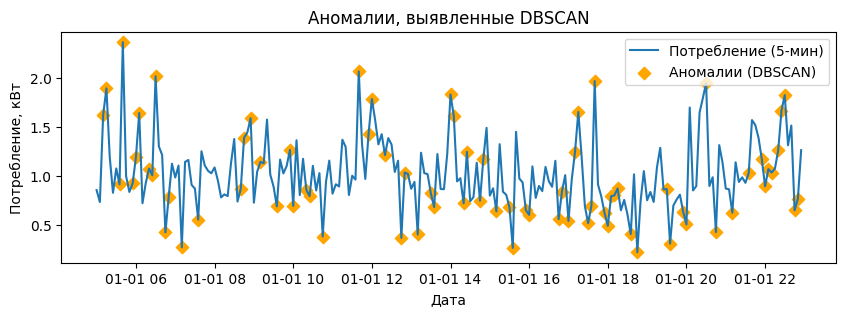

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(df_5min.index, df_5min['House overall [kW]'], label='Потребление (5-мин)')
plt.scatter(outlier_dbscan_indices, df_5min.loc[outlier_dbscan_indices, 'House overall [kW]'],
            color='orange', marker='D', s=40, label='Аномалии (DBSCAN)')
plt.title("Аномалии, выявленные DBSCAN")
plt.xlabel("Дата")
plt.ylabel("Потребление, кВт")
plt.legend()
plt.show()

## 4. Интерпретация результатов и рекомендации

На основе полученного анализа можно сделать следующие выводы:

- **Суточная динамика:** Потребление имеет выраженные минимумы ночью и пики утром/вечером. Это типичный паттерн для жилых домов.
- **Недельные особенности:** Выходные дни могут иметь более высокое дневное потребление по сравнению с буднями.
- **Влияние погоды:** Более низкая температура коррелирует с повышенным потреблением (отопление), а солнечные дни – с увеличением генерации от солнечных панелей.
- **Аномалии:**
  - Резкие ночные пики (например, значения 3–4 кВт) могут указывать на одновременное включение нескольких крупных приборов или сбой системы отопления.
  - Аномально низкие значения (близкие к 0) могут свидетельствовать о сбоях датчиков или аварийных отключениях.

**Рекомендации:**

- Оптимизировать работу системы отопления, чтобы избежать резких пиков нагрузки (например, распределить включение приборов).
- При обнаружении длительных периодов нулевого потребления проверить корректность работы датчиков и, при необходимости, обратиться к энергопоставщику.
- Использовать возможности солнечной генерации для снижения нагрузки в дневное время.
- Рассмотреть возможность автоматического управления нагрузкой (например, программируемый термостат, ночной тариф) для снижения пиковых нагрузок.

## Заключение

В этой работе проведен комплексный анализ энергопотребления с использованием статистических методов и алгоритмов машинного обучения для выявления закономерностей и аномалий. Результаты показали, что энергопотребление имеет четко выраженную суточную динамику и зависит от погодных условий. Выявленные аномалии помогут в дальнейшем настроить систему мониторинга для своевременного обнаружения нештатных ситуаций, что позволит снизить потери энергии и повысить надежность электроснабжения дома.

Данный анализ может быть использован как основа для разработки системы автоматического контроля энергопотребления в умном доме.